# Ensemble Learning: Bagging, Boosting, and Stacking

## 1. Bagging (Bootstrap Aggregating)

**Definition:**
Bagging is an **ensemble learning technique** aimed at reducing the **variance** of a model by training multiple base learners on different **bootstrap samples** (sampling with replacement) of the dataset, and then aggregating their predictions.

**Mathematical Formulation:**
Given a dataset:
$$
D = \{(x_i, y_i)\}_{i=1}^n
$$

We create \( B \) bootstrap samples:
$$
D_1, D_2, \dots, D_B
$$

For each sample, we train a base learner \( h_b(x) \). The final prediction is:

- **Regression:**
$$
\hat{f}_{bag}(x) = \frac{1}{B} \sum_{b=1}^{B} h_b(x)
$$

- **Classification:**
$$
\hat{f}_{bag}(x) = \text{majority\_vote}\{h_1(x), h_2(x), \dots, h_B(x)\}
$$

**Key Insight:**
Bagging works best for **high-variance** models (like Decision Trees).
The most popular example is **Random Forest**, which adds an additional random feature selection step.

---

## 2. Boosting

**Definition:**
Boosting is an **iterative (sequential) ensemble technique** where each new weak learner focuses on the **errors (residuals)** of the previous learners. The goal is to reduce **bias and variance** simultaneously.

**AdaBoost Intuition:**
Start with equal weights for all samples:
$$
w_i = \frac{1}{n}
$$

At iteration \( t \), train a weak learner \( h_t(x) \) minimizing the **weighted error**:
$$
\epsilon_t = \sum_{i=1}^n w_i \mathbf{1}(h_t(x_i) \neq y_i)
$$

Compute the weight of the learner:
$$
\alpha_t = \frac{1}{2} \ln\frac{1-\epsilon_t}{\epsilon_t}
$$

Update sample weights:
$$
w_i \leftarrow w_i \cdot e^{-\alpha_t y_i h_t(x_i)}
$$
Normalize \( w_i \).

Final classifier:
$$
H(x) = \text{sign}\Big( \sum_{t=1}^T \alpha_t h_t(x) \Big)
$$

**Gradient Boosting:**
Instead of reweighting samples explicitly, models are fit to the **negative gradients of the loss function**. This connects boosting with gradient descent optimization.

**Key Insight:**
Boosting works best for **reducing bias**, but can overfit if not regularized (shrinkage, early stopping).

Popular algorithms: **AdaBoost, Gradient Boosting, XGBoost, LightGBM.**

---

## 3. Stacking (Stacked Generalization)

**Definition:**
Stacking is a **meta-learning technique** where predictions from multiple diverse models are combined using another model called the **meta-learner**.

**Process:**
1. Train base learners \( h_1, h_2, \dots, h_k \) on the training data.
2. Generate a meta-feature matrix \( Z \):
$$
Z = [h_1(x), h_2(x), \dots, h_k(x)]
$$
3. Train a meta-learner \( g \) on \( Z \) to produce the final prediction:
$$
\hat{y} = g(Z)
$$

**Key Insight:**
Stacking leverages **model diversity** and allows the meta-learner to learn the optimal combination of models.

It requires careful **cross-validation** to avoid overfitting and data leakage.

---

## 4. Key Differences

| Technique | Training Type | Goal | Example Models |
|-----------|---------------|------|----------------|
| Bagging   | Parallel (independent learners) | Reduce variance | Random Forest |
| Boosting  | Sequential (each learner fixes previous errors) | Reduce bias & variance | AdaBoost, XGBoost |
| Stacking  | Parallel + Meta-model | Learn optimal model combination | Kaggle meta-models |

---

## 5. Theoretical Insights

- **Bias-Variance Trade-off:**
  - Bagging: Primarily reduces variance.
  - Boosting: Reduces bias and variance.
  - Stacking: Exploits strengths of heterogeneous models.

- **Generalization:**
  Stacking often achieves the best performance when the base models are diverse and the meta-learner is chosen carefully.

---

## References
- Breiman, L. (1996). *Bagging Predictors*. Machine Learning.
- Freund, Y., & Schapire, R. (1997). *A Decision-Theoretic Generalization of On-Line Learning and an Application to Boosting*.
- Wolpert, D. (1992). *Stacked Generalization*.


In [8]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,StackingClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [9]:
data=load_breast_cancer()
X,y =data.data,data.target

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.3,stratify=y)


In [10]:
#################### Bagging ####################
bag_base=DecisionTreeClassifier(max_depth=5,random_state=42)
bag_model=BaggingClassifier(estimator=bag_base,n_estimators=50,random_state=42)
bag_model.fit(X_train,y_train)
bag_pred=bag_model.predict(X_test)
bag_acc=accuracy_score(y_test,bag_pred)
print("Bagging accuracy",bag_acc)


Bagging accuracy 0.935672514619883


In [11]:
#### boosting #####
## Adaboost ##

ada_model=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),n_estimators=100,learning_rate=0.5,random_state=42)
ada_model.fit(X_train,y_train)
ada_pred=ada_model.predict(X_test)
ada_acc=accuracy_score(y_test,ada_pred)
print("AdaBoost accuracy",ada_acc)

## gradient boosting
gb_model=GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,random_state=42)
gb_model.fit(X_train,y_train)
gb_pred=gb_model.predict(X_test)
gb_acc=accuracy_score(y_test,gb_pred)
print("Gradient boosting accuracy",gb_acc)

AdaBoost accuracy 0.9532163742690059
Gradient boosting accuracy 0.9473684210526315


In [12]:
###### Stacking ######

scaled_lr=make_pipeline(StandardScaler(),LogisticRegression(max_iter=2000,solver='lbfgs'))
base_learners=[
    ('dt',DecisionTreeClassifier(max_depth=5,random_state=42)),
    ('svc',make_pipeline(StandardScaler(),SVC(kernel='rbf',probability=True,random_state=42))),
    ('lr',scaled_lr)
]

meta_learner=GradientBoostingClassifier(n_estimators=50,random_state=42)

stack_model=StackingClassifier(estimators=base_learners,final_estimator=meta_learner,cv=5)
stack_model.fit(X_train,y_train)
stack_pred=stack_model.predict(X_test)
stack_acc=accuracy_score(y_test,stack_pred)
print("stacking accuracy",stack_acc)


stacking accuracy 0.9883040935672515


In [13]:
models={
    "Bagging": bag_model,
    "AdaBoost": ada_model,
    "GradientBoosting": gb_model,
    "Stacking": stack_model
}

print("cross validation means scores: ")
for name,model in models.items():
    scores=cross_val_score(model,X,y,cv=5)
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

cross validation means scores: 
Bagging: 0.9508 (+/- 0.0307)
AdaBoost: 0.9701 (+/- 0.0153)
GradientBoosting: 0.9631 (+/- 0.0210)
Stacking: 0.9702 (+/- 0.0142)


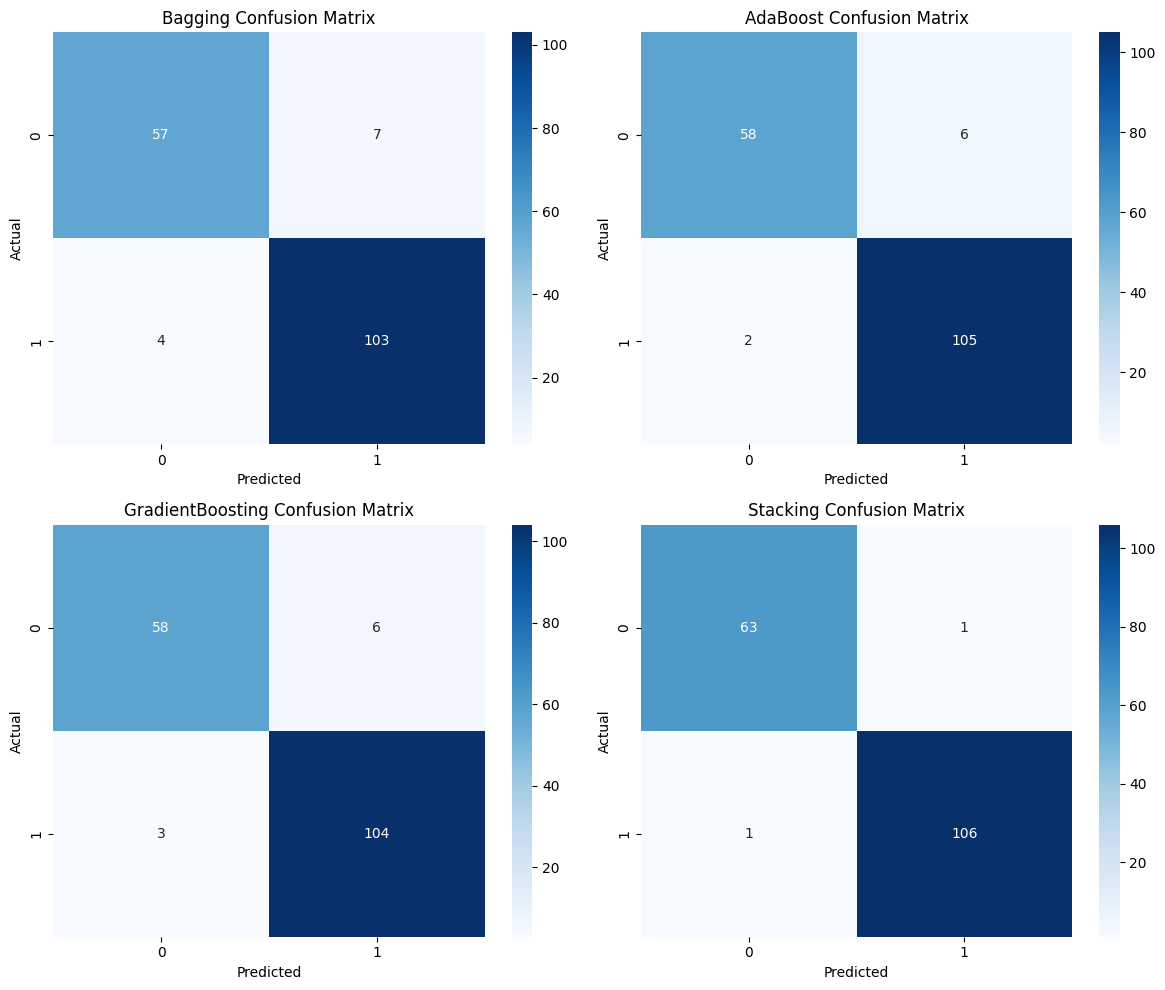

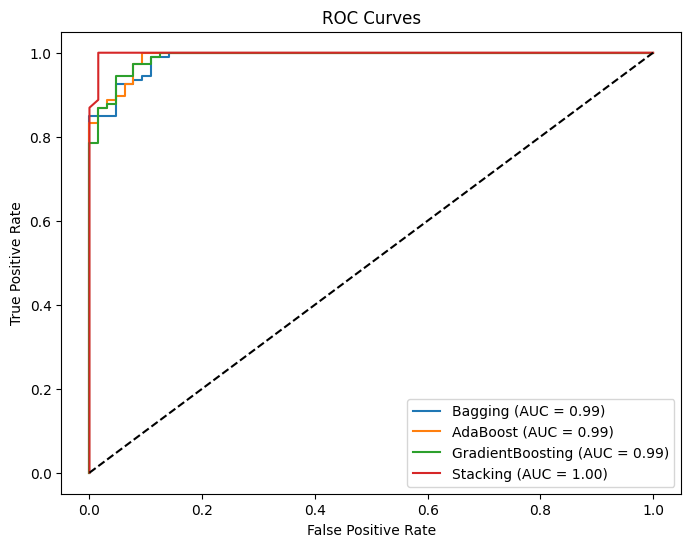

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,roc_auc_score,auc,roc_curve

models_to_plot = {
    "Bagging": bag_model,
    "AdaBoost": ada_model,
    "GradientBoosting": gb_model,
    "Stacking": stack_model
}

plt.figure(figsize=(12,10))
for i,(name,model) in enumerate(models_to_plot.items(),1):
    y_pred=model.predict(X_test)
    cm=confusion_matrix(y_test,y_pred)
    plt.subplot(2,2,i)
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
for name, model in models_to_plot.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        # for SVC inside stacking, use decision_function
        y_score = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Random guess line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()